In [31]:
import os
import random
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import plot_model
import pandas as pd
import cv2 
from PIL import Image

# Data directory

In [32]:
acceptable_extensions = ['.jpg', '.jpeg', '.png']
data_dir = 'FIR2013'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Data cleaning function

In [33]:
for root,dirs,files in os.walk(data_dir):
    try:
        for file in files:
            if not file.endswith(tuple(acceptable_extensions)):
                print(os.path.join(root, file))
                os.remove(os.path.join(root, file))
    except Exception as e:
        print(e)
        os.remove(os.path.join(root, file))


In [34]:
def count_files(directory,set):
    counts = {}
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        
        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))
    return pd.DataFrame(counts,index=[set])

train_counts = count_files(train_dir, 'train_count')
test_counts = count_files(test_dir, 'test_count')
print(train_counts)
print(test_counts)


             angry  disgust  fear  happy  neutral   sad  surprise
train_count   3995      436  4097   7215     4965  4830      3171
            angry  disgust  fear  happy  neutral   sad  surprise
test_count    958      111  1024   1774     1233  1247       831


<Axes: >

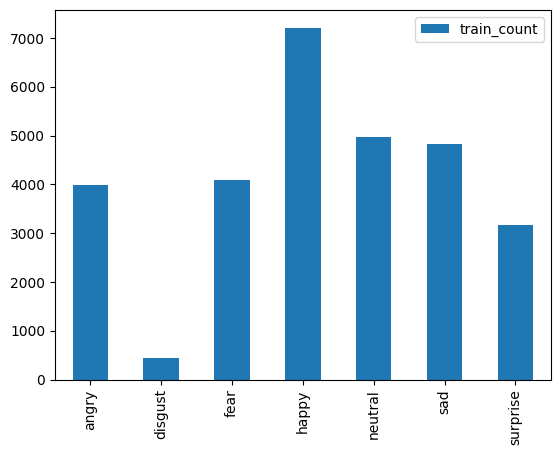

In [35]:
train_counts.transpose().plot(kind='bar')

<Axes: >

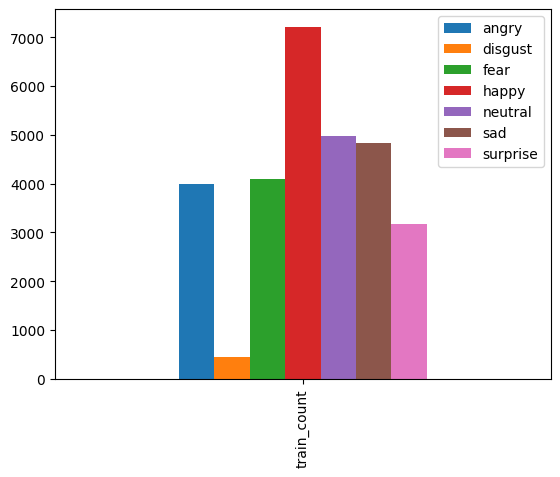

In [36]:
train_counts.plot(kind='bar')

<Axes: >

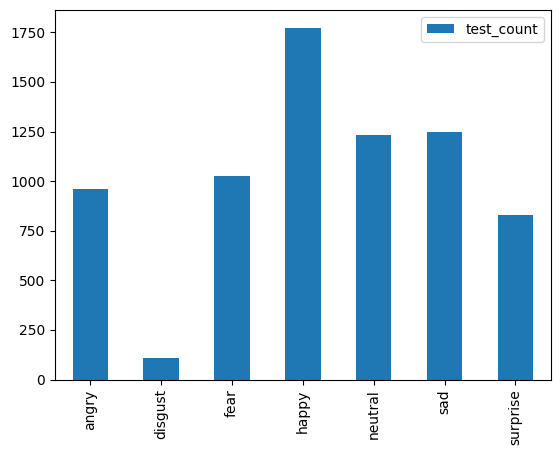

In [37]:
test_counts.transpose().plot(kind='bar')

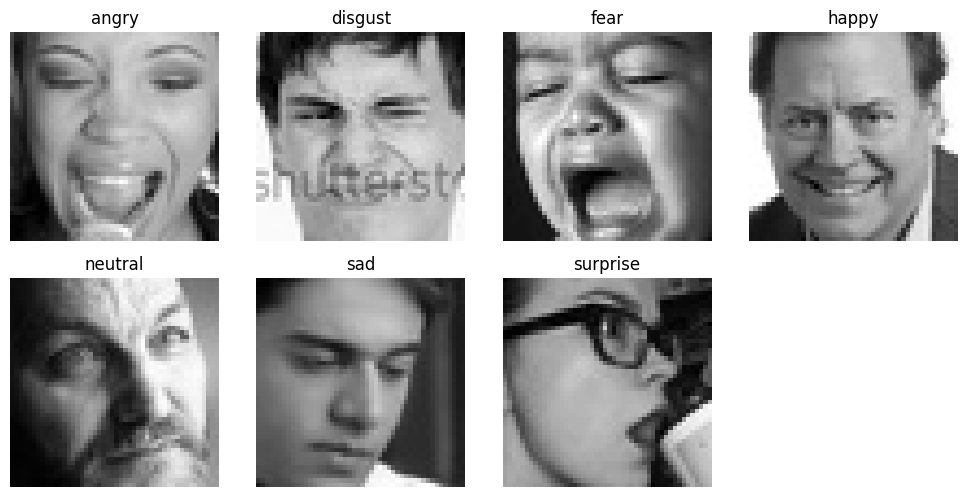

In [38]:
i=1
plt.figure(figsize=(10,10))
for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    image = plt.imread(os.path.join(class_path, random.choice(os.listdir(class_path))))
    plt.subplot(4, 4, i)
    plt.imshow(image, cmap='gray')
    plt.title(cls)
    plt.axis('off')
    plt.tight_layout()
    i+=1

In [39]:
os.listdir(train_dir)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Setting parameters

In [40]:
image_width = 48
image_height = 48
batch_size = 150
epochs = 20
number_of_classes = len(os.listdir(train_dir))
color_mode = 'grayscale'

In [41]:
data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_generator.flow_from_directory(train_dir, target_size=(image_width, image_height), batch_size=batch_size, subset='training',color_mode=color_mode)
validation_generator = data_generator.flow_from_directory(train_dir, target_size=(image_width, image_height), batch_size=batch_size, subset='validation',color_mode=color_mode)
test_generator = data_generator.flow_from_directory(test_dir, target_size=(image_width, image_height), batch_size=batch_size, color_mode=color_mode)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [42]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import layers, models, regularizers, optimizers
model = keras.models.Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(image_width, image_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(number_of_classes))
model.add(Activation('softmax'))

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
train_steps = train_generator.samples // train_generator.batch_size + 1
validation_steps = validation_generator.samples // validation_generator.batch_size + 1

In [45]:
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/20
154/154 [==============================] - 29s 146ms/step - loss: 10.7071 - accuracy: 0.2528 - val_loss: 24.5865 - val_accuracy: 0.2513
Epoch 2/20
154/154 [==============================] - 21s 136ms/step - loss: 3.5517 - accuracy: 0.3187 - val_loss: 14.2854 - val_accuracy: 0.2513
Epoch 3/20
154/154 [==============================] - 21s 136ms/step - loss: 2.1767 - accuracy: 0.3612 - val_loss: 8.8043 - val_accuracy: 0.2513
Epoch 4/20
154/154 [==============================] - 21s 136ms/step - loss: 1.8389 - accuracy: 0.4044 - val_loss: 2.2303 - val_accuracy: 0.3310
Epoch 5/20
154/154 [==============================] - 21s 136ms/step - loss: 1.7287 - accuracy: 0.4355 - val_loss: 1.9565 - val_accuracy: 0.3390
Epoch 6/20
154/154 [==============================] - 21s 136ms/step - loss: 1.6581 - accuracy: 0.4557 - val_loss: 2.0712 - val_accuracy: 0.3362
Epoch 7/20
154/154 [==============================] - 21s 136ms/step - loss: 1.6174 - accuracy: 0.4705 - val_loss: 1.6562 - val